In [45]:
import warnings

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import single, complete, average, weighted, centroid, median, ward, fcluster, cophenet, leaves_list
import scipy.cluster.hierarchy

import pandas as pd
import numpy as np
from numpy import linalg as la

import matplotlib.pyplot as plt
import plotly.express as px


from umap import UMAP
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve

plt.style.use('dark_background')

In [46]:
warnings.filterwarnings('ignore')
df = pd.read_csv("SCADI.csv")
df.head()

,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-8,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,class6
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,class6
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,class6


In [47]:
print(df.dtypes)
df.describe()

Gender       int64
Age          int64
d 5100-0     int64
d 5100-1     int64
d 5100-2     int64
             ...  
d 571-3      int64
d 571-4      int64
d 571-8      int64
d 571-9      int64
Classes     object
Length: 206, dtype: object


,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-4,d 57022-8,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.0,70.0,70.0,...,70.000000,70.0,70.0,70.000000,70.000000,70.000000,70.000000,70.000000,70.0,70.0
mean,0.414286,12.257143,0.071429,0.142857,0.271429,0.171429,0.342857,0.0,0.0,0.0,...,0.014286,0.0,0.0,0.114286,0.328571,0.314286,0.157143,0.085714,0.0,0.0
std,0.496155,3.626336,0.259399,0.352454,0.447907,0.379604,0.478091,0.0,0.0,0.0,...,0.119523,0.0,0.0,0.320455,0.473085,0.467583,0.366563,0.281963,0.0,0.0
min,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,15.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0
max,1.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [48]:
df['Gender'] = pd.Categorical(df['Gender'])
df['Age'] = pd.to_numeric(df['Age'])

# remove string "class" from Classes attribute
df['Classes'] = df['Classes'].str.replace('class','')
df['Classes'] = pd.Categorical(df['Classes'])
df.head()

# data is sparse

,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-8,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,6
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,6
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,6
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,6


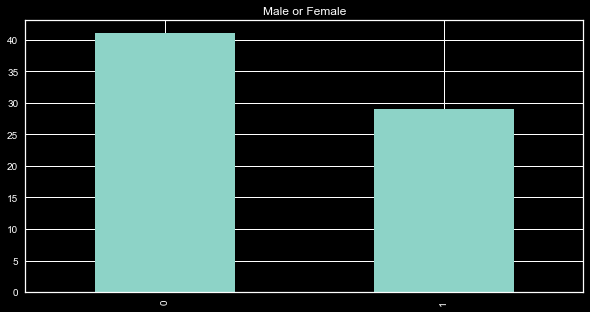

In [49]:
plt.figure(figsize= (10,5))
plt.title('Male or Female')
df['Gender'].value_counts().plot(kind='bar')
plt.show()



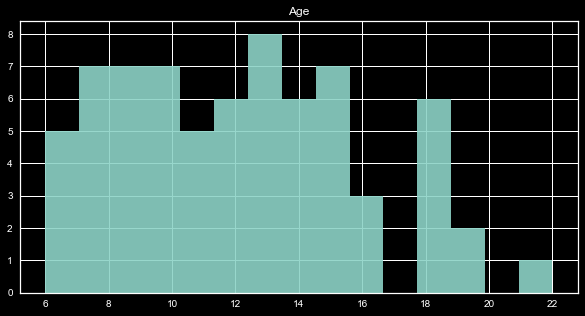

In [50]:
plt.figure(figsize= (10,5))
plt.title('Age')
df['Age'].hist(bins=15, alpha=0.9)
plt.show()


In [51]:
umap_2d = UMAP(random_state=0)
umap_2d.fit(df)

projections = umap_2d.transform(df)

fig = px.scatter(
    projections, x=0, y=1,
    color=df['Classes'], labels={'color': 'class'}
)
fig.show()

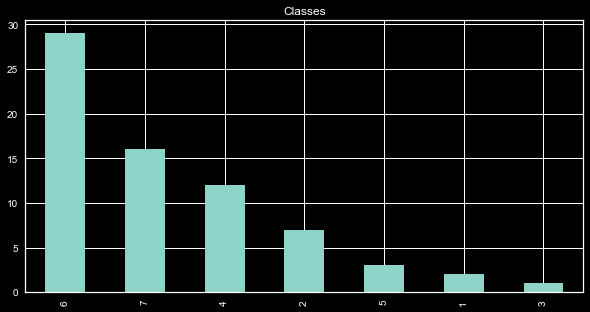

In [52]:
plt.figure(figsize= (10, 5))
plt.title('Classes')
df['Classes'].value_counts().plot(kind='bar')
plt.show()

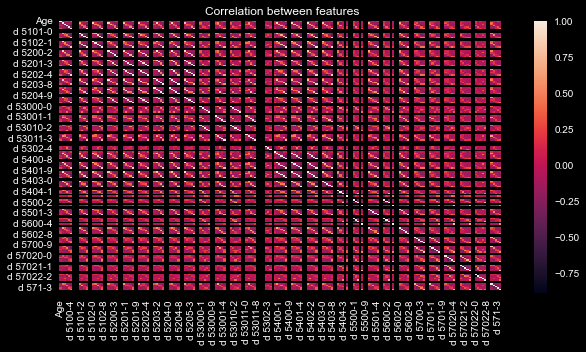

In [53]:
correlation = df.corr()
plt.figure(figsize= (10,5))
plt.title('Correlation between features')
sns.heatmap(correlation)
plt.show()

In [54]:
np.random.seed(42)


def flip_signs(A, B):

    signs = np.sign(A) * np.sign(B)
    return A, B * signs


# Let the data matrix X be of n x p size,
# where n is the number of samples and p is the number of variables
n, p = 5, 3
X = np.random.rand(n, p)
# Let us assume that it is centered
X -= np.mean(X, axis=0)

# the p x p covariance matrix
C = np.cov(X, rowvar=False)
print ("C = \n", C)
# C is a symmetric matrix and so it can be diagonalized:
l, principal_axes = la.eig(C)
# sort results wrt. eigenvalues
idx = l.argsort()[::-1]
l, principal_axes = l[idx], principal_axes[:, idx]
# the eigenvalues in decreasing order
print("l = \n", l)
# a matrix of eigenvectors (each column is an eigenvector)
print("V = \n", principal_axes)
# projections of X on the principal axes are called principal components
principal_components = X.dot(principal_axes)
print("Y = \n", principal_components)

# we now perform singular value decomposition of X
# "economy size" (or "thin") SVD
U, s, Vt = la.svd(X, full_matrices=False)
V = Vt.T
S = np.diag(s)

# 1) then columns of V are principal directions/axes.
assert np.allclose(*flip_signs(V, principal_axes))

# 2) columns of US are principal components
assert np.allclose(*flip_signs(U.dot(S), principal_components))

# 3) singular values are related to the eigenvalues of covariance matrix
assert np.allclose((s ** 2) / (n - 1), l)

# 8) dimensionality reduction
k = 2
PC_k = principal_components[:, 0:k]
US_k = U[:, 0:k].dot(S[0:k, 0:k])
assert np.allclose(*flip_signs(PC_k, US_k))

# 10) we used "economy size" (or "thin") SVD
assert U.shape == (n, p)
assert S.shape == (p, p)
assert V.shape == (p, p)


C = 
 [[ 0.09338628 -0.11086559 -0.02943783]
 [-0.11086559  0.18770817  0.0336127 ]
 [-0.02943783  0.0336127   0.12511719]]
l = 
 [0.27418905 0.11232653 0.01969604]
V = 
 [[ 0.53435576  0.10510519 -0.83869948]
 [-0.79577968 -0.27194755 -0.54109078]
 [-0.28495372  0.95655498 -0.06167616]]
Y = 
 [[-0.5382821   0.04170504 -0.17101639]
 [ 0.37801268 -0.26959854  0.10654358]
 [-0.60281427 -0.09375913  0.14821045]
 [ 0.31232627  0.5572872   0.03786103]
 [ 0.45075742 -0.23563458 -0.12159868]]


In [55]:
#PCA
df_pca = df.copy()
pca = PCA(n_components=50)
PC = pca.fit_transform(df_pca)
PC

array([[ 6.07666022e+00, -2.09416630e+00, -5.83088226e-01, ...,
        -1.06182164e-01,  1.48547492e-01,  1.05770908e-02],
       [ 1.00983948e+01, -1.48253601e+00,  4.36643702e-01, ...,
        -6.39787924e-02, -8.09938536e-03,  1.42351300e-01],
       [ 6.03346800e+00, -1.03064885e+00, -2.01283150e-02, ...,
        -1.94194938e-02, -6.41159126e-02, -1.35495976e-02],
       ...,
       [-4.11522244e+00, -1.66734894e+00, -2.16306600e+00, ...,
        -1.60753202e-01, -1.27221750e-01,  2.14166989e-02],
       [-4.01745205e+00, -2.41430251e+00, -2.15380109e+00, ...,
         3.05332008e-02,  3.03484290e-02,  8.64317629e-02],
       [ 1.82746277e+00, -1.81858582e+00, -1.48038105e+00, ...,
        -2.86350711e-02,  1.18894919e-01, -1.31288337e-01]])

In [56]:
print('Features before PCA: ', df_pca.shape[1])
print('Features after PCA: ', PC.shape[1])
print('Sum of Variance', pca.explained_variance_ratio_.sum())

Features before PCA:  206
Features after PCA:  50
Sum of Variance 0.9977534323240367


In [57]:
pca.get_covariance()

array([[ 2.46131660e-01, -3.97952374e-01,  1.35529392e-02, ...,
         0.00000000e+00,  0.00000000e+00, -9.36235249e-02],
       [-3.97952374e-01,  1.31503115e+01, -2.21520151e-01, ...,
         0.00000000e+00,  0.00000000e+00, -6.46792779e-01],
       [ 1.35529392e-02, -2.21520151e-01,  7.04693634e-02, ...,
         0.00000000e+00,  0.00000000e+00,  1.26265408e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.01561181e-03,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.01561181e-03,  0.00000000e+00],
       [-9.36235249e-02, -6.46792779e-01,  1.26265408e-01, ...,
         0.00000000e+00,  0.00000000e+00,  2.88947945e+00]])

In [58]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.38631219, 0.16508091, 0.08786341, 0.07000343, 0.03344278,
       0.02610208, 0.025546  , 0.02023758, 0.0179229 , 0.01541195,
       0.01423061, 0.01313145, 0.01098159, 0.00934976, 0.00868466,
       0.00834496, 0.00686443, 0.00661122, 0.00598969, 0.00597938,
       0.00548223, 0.00443756, 0.00432288, 0.00405243, 0.00375192,
       0.00350874, 0.00296479, 0.00290501, 0.00270109, 0.00258195,
       0.00226606, 0.00224356, 0.00190632, 0.00183536, 0.00162495,
       0.00152894, 0.00140161, 0.0012861 , 0.0011459 , 0.00106003,
       0.00101869, 0.00091979, 0.00083444, 0.00075194, 0.00061497,
       0.00057475, 0.00052915, 0.00052231, 0.00046778, 0.00042118])

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

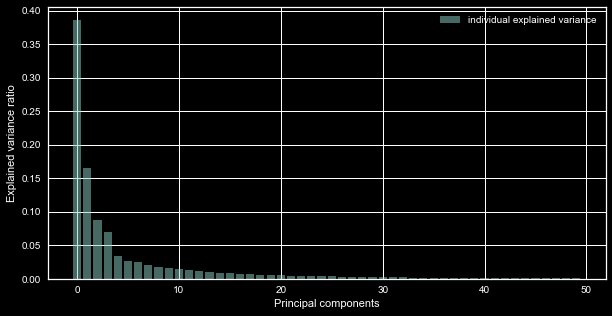

In [59]:
plt.figure(figsize = (10,5))
plt.bar(range(50), explained_variance, alpha=0.5,
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout

In [60]:
df_truncatedSVD = df.copy()
truncatedSVD = TruncatedSVD(n_components=50, random_state=40)
sparse_truncatedSVD = truncatedSVD.fit_transform(df_truncatedSVD)
sparse_truncatedSVD

array([[ 1.93113588e+01, -4.51268865e-01, -2.74915018e+00, ...,
         8.90968742e-02,  9.39022465e-02,  9.23550649e-02],
       [ 2.30288934e+01,  9.93368680e-01, -3.28972418e+00, ...,
         1.23769952e-01, -4.46719234e-03,  8.90660071e-02],
       [ 1.93537932e+01,  3.70027247e-01, -1.88553497e+00, ...,
        -1.40446880e-01,  9.41328941e-02, -8.85963915e-02],
       ...,
       [ 1.01298366e+01, -2.59149742e+00,  2.30757461e-01, ...,
         1.36176958e-01,  9.41321467e-02, -9.39643489e-02],
       [ 1.00475120e+01, -3.10275453e+00, -4.79408934e-01, ...,
        -2.38746068e-02, -2.32965294e-02,  6.68204355e-02],
       [ 1.55460081e+01, -1.25251141e+00, -1.54816562e+00, ...,
         9.52800714e-03,  4.85089472e-02,  2.31360491e-02]])

In [61]:
print('Features before TSVD: ', df_truncatedSVD.shape[1])
print('Features after TSVD: ', sparse_truncatedSVD.shape[1])
print('Sum of Variance', truncatedSVD.explained_variance_ratio_.sum())

Features before TSVD:  206
Features after TSVD:  50
Sum of Variance 0.9973680531057599


In [62]:
pca_X = PC
pca_y = df.loc[:, 'Classes'].astype(int)
pca_y = pca_y.values
print(pca_y.shape)

pca_y = pca_y.flatten()
pca_y

(70,)


array([6, 6, 6, 6, 6, 2, 6, 2, 4, 7, 4, 7, 4, 7, 4, 6, 7, 6, 2, 4, 7, 7,
       2, 6, 6, 6, 7, 6, 1, 6, 7, 7, 6, 6, 6, 6, 7, 4, 6, 5, 5, 2, 7, 7,
       7, 4, 1, 2, 6, 7, 7, 4, 6, 6, 6, 2, 5, 6, 6, 6, 6, 4, 4, 7, 4, 4,
       3, 6, 6, 6])

In [63]:
# find best linkage type and distance metric for the clustering algorithm.
# using manhattan and euclidean
DISTANCES = ['cityblock', 'euclidean']
pca_z = []
# find pairwise distances between observations in n-dimensional space.
for distance in DISTANCES:
    pca_z.append(pdist(pca_X, distance))

# include all linkage methods provided by SciPy
linkage = [single, complete, average, weighted, centroid, median, ward]
pca_data = []
for link in linkage:
    # maxclust finds a minimum threshold r so that the
    # cophenetic distance (measure of how similar those two objects have
    # to be in order to be grouped into the same cluster) between any two original observations
    # in the same flat cluster is no more than r and no more than t
    # flat clusters are formed.
    pca_clusters = (fcluster(link(pca_z[1]), t=7, criterion='maxclust'))
    pca_data.append(({
        'ARI':metrics.adjusted_rand_score(pca_y, pca_clusters),
        'Completeness':metrics.completeness_score(pca_y, pca_clusters),
        'Silhouette':metrics.silhouette_score(pca_X, pca_clusters)
    }))
pca_results = pd.DataFrame(data=pca_data, columns= ["ARI", "Completeness", 'Silhouette'],
                           index=['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
                           )
pca_results






,ARI,Completeness,Silhouette
single,0.219901,0.628513,-0.041931
complete,0.211473,0.437577,0.136175
average,0.454680,0.552395,0.232927
weighted,0.212566,0.455452,0.141088
centroid,-0.041235,0.336660,0.111448
median,0.049014,0.438335,0.075128
ward,0.464396,0.571747,0.230193


In [64]:
tsvd_X = sparse_truncatedSVD
tsvd_y = df.loc[:, 'Classes'].astype(int)
tsvd_y = tsvd_y.values
print(tsvd_y.shape)

tsvd_y = tsvd_y.flatten()
print(tsvd_y)

(70,)
[6 6 6 6 6 2 6 2 4 7 4 7 4 7 4 6 7 6 2 4 7 7 2 6 6 6 7 6 1 6 7 7 6 6 6 6 7
 4 6 5 5 2 7 7 7 4 1 2 6 7 7 4 6 6 6 2 5 6 6 6 6 4 4 7 4 4 3 6 6 6]


In [65]:
# find best linkage type and distance metric for the clustering algorithm.
# using manhattan and euclidean
DISTANCES = ['cityblock', 'euclidean']
tsvd_z = []
# find pairwise distances between observations in n-dimensional space.
for distance in DISTANCES:
    tsvd_z.append(pdist(tsvd_X, distance))

# include all linkage methods provided by SciPy
linkage = [single, complete, average, weighted, centroid, median, ward]
tsvd_data = []
for link in linkage:
    # maxclust finds a minimum threshold r so that the
    # cophenetic distance (measure of how similar those two objects have
    # to be in order to be grouped into the same cluster) between any two original observations
    # in the same flat cluster is no more than r and no more than t
    # flat clusters are formed.
    tsvd_clusters = (fcluster(link(tsvd_z[1]), t=7, criterion='maxclust'))
    tsvd_data.append(({
        'ARI':metrics.adjusted_rand_score(tsvd_y, tsvd_clusters),
        'Completeness':metrics.completeness_score(tsvd_y, tsvd_clusters),
        'Silhouette':metrics.silhouette_score(tsvd_X, tsvd_clusters)
    }))
tsvd_results = pd.DataFrame(data=tsvd_data, columns= ["ARI", "Completeness", "Silhouette"],
                           index=['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
                           )
tsvd_results


,ARI,Completeness,Silhouette
single,0.219901,0.628513,-0.042088
complete,0.211473,0.437577,0.136276
average,0.454680,0.552395,0.233113
weighted,0.212566,0.455452,0.141142
centroid,-0.041235,0.336660,0.111320
median,0.049014,0.438335,0.075075
ward,0.464396,0.571747,0.230340


In [66]:
print(pca_results)

print(tsvd_results)

               ARI  Completeness  Silhouette
single    0.219901      0.628513   -0.041931
complete  0.211473      0.437577    0.136175
average   0.454680      0.552395    0.232927
weighted  0.212566      0.455452    0.141088
centroid -0.041235      0.336660    0.111448
median    0.049014      0.438335    0.075128
ward      0.464396      0.571747    0.230193
               ARI  Completeness  Silhouette
single    0.219901      0.628513   -0.042088
complete  0.211473      0.437577    0.136276
average   0.454680      0.552395    0.233113
weighted  0.212566      0.455452    0.141142
centroid -0.041235      0.336660    0.111320
median    0.049014      0.438335    0.075075
ward      0.464396      0.571747    0.230340


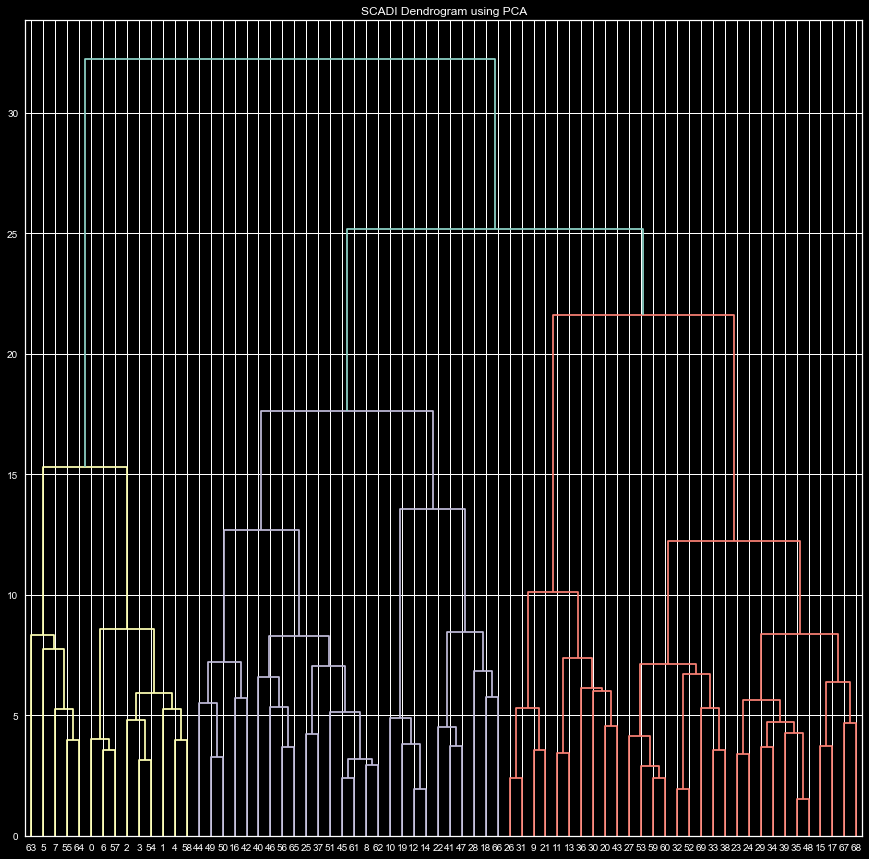

In [67]:
plt.figure(figsize=(15,15))
plt.title("SCADI Dendrogram using PCA")
pca_dendrogram = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(PC, method='ward'),orientation='top')
plt.tick_params(axis='x', labelsize=10, rotation='auto')


In [68]:
pca_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
pca_cluster_pred = pca_cluster.fit_predict(PC)
pca_cluster_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 3, 3,
       0, 2, 2, 0, 3, 2, 0, 2, 3, 3, 2, 2, 2, 2, 3, 0, 2, 2, 0, 0, 0, 3,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 0,
       0, 2, 2, 2])

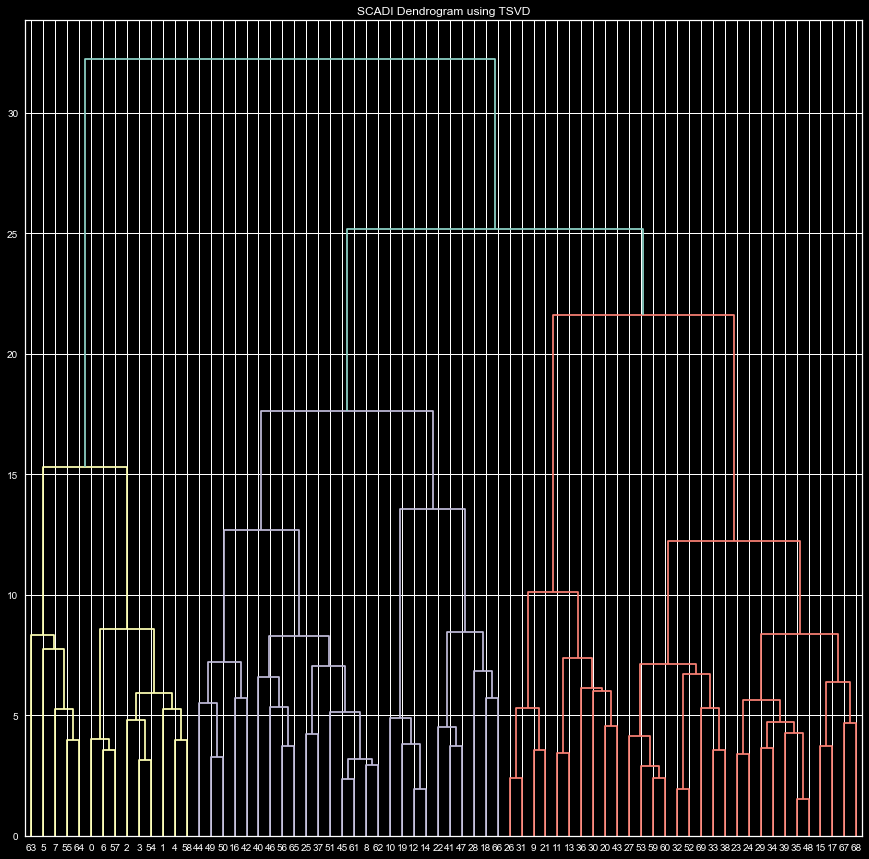

In [69]:
plt.figure(figsize=(15,15))
plt.title("SCADI Dendrogram using TSVD")
pca_dendrogram = scipy.cluster.hierarchy.dendrogram(scipy.cluster.hierarchy.linkage(sparse_truncatedSVD, method='ward'),orientation='top')
plt.tick_params(axis='x', labelsize=10, rotation='auto')
plt.savefig('dend_tsvd.png')


In [70]:
tsvd_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
tsvd_cluster_pred = tsvd_cluster.fit_predict(sparse_truncatedSVD)
tsvd_cluster_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 3, 3,
       0, 2, 2, 0, 3, 2, 0, 2, 3, 3, 2, 2, 2, 2, 3, 0, 2, 2, 0, 0, 0, 3,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 1, 1, 0,
       0, 2, 2, 2])

In [71]:
df_pca['Cluster'] = pca_cluster_pred
df_truncatedSVD['Cluster'] = tsvd_cluster_pred


In [72]:
df_pca.head()


,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes,Cluster
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,6,1
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,6,1
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,6,1
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,6,1
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,6,1


In [73]:
df_truncatedSVD.head()

,Gender,Age,d 5100-0,d 5100-1,d 5100-2,d 5100-3,d 5100-4,d 5100-8,d 5100-9,d 5101-0,...,d 57022-9,d 571-0,d 571-1,d 571-2,d 571-3,d 571-4,d 571-8,d 571-9,Classes,Cluster
0,0,18,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,6,1
1,0,22,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,6,1
2,0,18,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,6,1
3,1,18,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,6,1
4,0,19,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,6,1


In [74]:
print("Median age per cluster using PCA\n", df_pca.groupby('Cluster')['Age'].median())
print("\nGender per cluster using PCA\n", df_pca.groupby('Cluster')['Gender'].value_counts())

Median age per cluster using PCA
 Cluster
0    12.0
1    18.0
2    11.0
3     9.0
Name: Age, dtype: float64

Gender per cluster using PCA
 Cluster   
0        1    14
         0    12
1        0    10
         1     4
2        0    14
         1     6
3        0     5
         1     5
Name: Gender, dtype: int64


In [75]:
print("Median age per cluster using TSVD\n", df_truncatedSVD.groupby('Cluster')['Age'].median())
print("\nGender per cluster using TSVD\n", df_truncatedSVD.groupby('Cluster')['Gender'].value_counts())

Median age per cluster using TSVD
 Cluster
0    12.0
1    18.0
2    11.0
3     9.0
Name: Age, dtype: float64

Gender per cluster using TSVD
 Cluster   
0        1    14
         0    12
1        0    10
         1     4
2        0    14
         1     6
3        0     5
         1     5
Name: Gender, dtype: int64


In [76]:
# At this point, I don't really see difference between PCA and TSVD. I feel like I missed something,
# but I followed the documentation carefully.

In [77]:
print("\n(TSVD) Classes per cluster\n", df_truncatedSVD.groupby('Cluster')['Classes'].value_counts())


(TSVD) Classes per cluster
 Cluster   
0        4    11
         7     5
         2     4
         1     2
         5     2
         3     1
         6     1
1        6     9
         2     3
         4     1
         7     1
         1     0
         3     0
         5     0
2        6    19
         5     1
         1     0
         2     0
         3     0
         4     0
         7     0
3        7    10
         1     0
         2     0
         3     0
         4     0
         5     0
         6     0
Name: Classes, dtype: int64


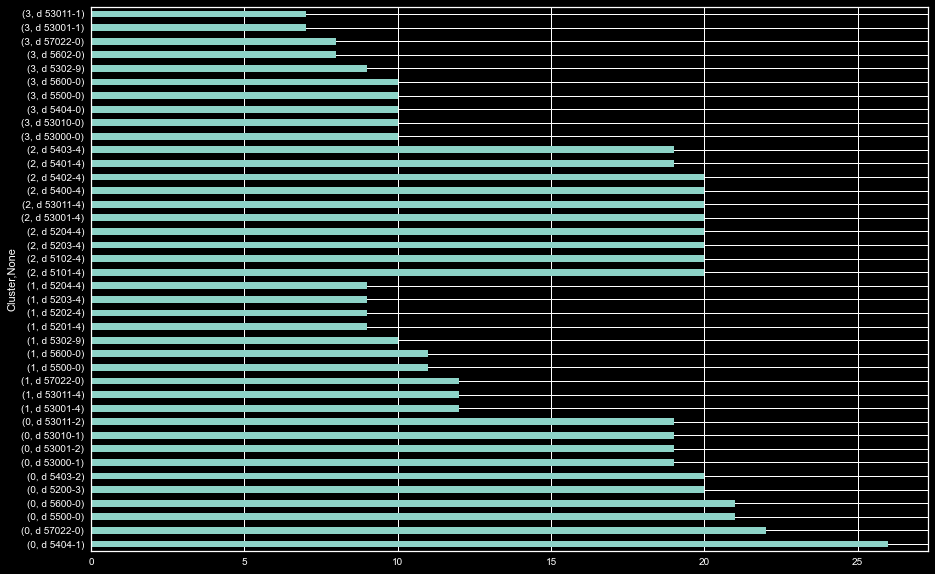

In [78]:
plt.figure(figsize=(15,10))
df_truncatedSVD.groupby('Cluster').apply(lambda x: x.iloc[:,2:-2].sum().nlargest(10)).plot(kind='barh')
plt.show()

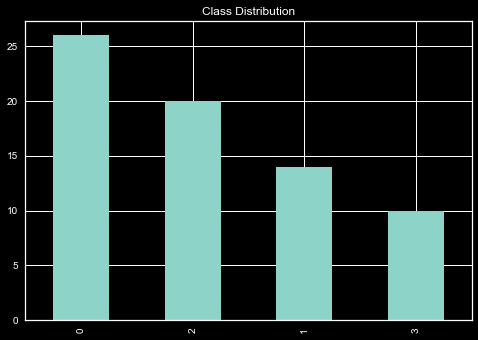

In [79]:
plt.title('Class Distribution')
df_truncatedSVD.Cluster.value_counts().plot(kind='bar')
plt.show()

In [80]:
X,y = sparse_truncatedSVD, df_truncatedSVD['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

X_train.shape

(49, 50)

In [81]:
y_train.shape


(49,)

In [82]:
X_test.shape


(21, 50)

In [83]:
y_test.shape

(21,)

In [84]:
rfclf = RandomForestClassifier(n_estimators=100, random_state=42)
rfclf.fit(X_train,y_train)
y_pred=rfclf.predict(X_test)

In [85]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.9047619047619048


In [86]:
rfclf_cv_score = cross_val_score(rfclf, X, y, cv=10, scoring='f1_micro')
print("=== All AUC Scores ===")
print(rfclf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfclf_cv_score.mean())


=== All AUC Scores ===
[1.         1.         1.         0.85714286 1.         1.
 1.         1.         0.71428571 0.85714286]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9428571428571428


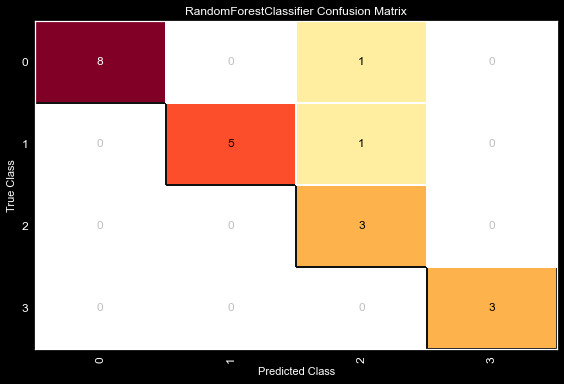

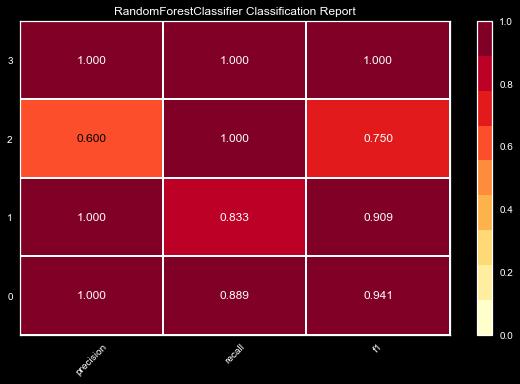

In [89]:
conf_matrix = ConfusionMatrix(rfclf)

conf_matrix.fit(X_train, y_train)
conf_matrix.score(X_test, y_test)
print_conf_matrix = conf_matrix.poof()

classification_report = ClassificationReport(rfclf)

classification_report.fit(X_train, y_train)
classification_report.score(X_test, y_test)
print_classification_report = classification_report.poof()

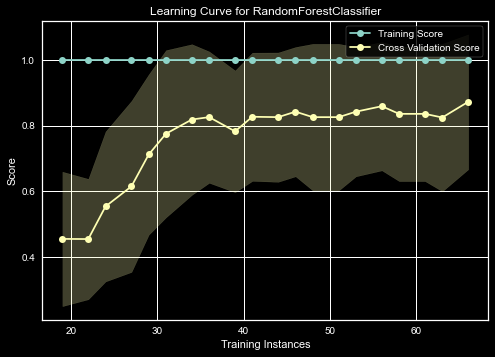

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [88]:
cross_validation = StratifiedKFold(n_splits=20)
train_sizes = np.linspace(0.3, 1.0, 20)

learning_curve = LearningCurve(
    rfclf, cv=cross_validation, scoring='f1_weighted', train_sizes=train_sizes, n_jobs=4
)

learning_curve.fit(X, y)
learning_curve.poof()